In [1]:
%load_ext autoreload
%autoreload 2

# Correlate mRNAs to RBS data

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from common import count_ARN_motifs, count_AAN_motifs, count_ARNn, count_A_richness, count_An, count_An_norm, load_df_Reis
from ViennaRNA import RNA
import sys


sns.set_style('whitegrid')

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)

In [3]:
from src.utils.visualisation import show_rna_structure, draw_rna_nucolor_varna


# Load RBS calculator stuff

In [4]:
top_dir = os.path.join('data', '22_analyse_RBS_data_Reis')
# Using Reis data
fn = os.path.join('data', 'RBS_Calculator', 'sb0c00394_si_002.xlsx')
excel_file = pd.ExcelFile(fn)

df = load_df_Reis(excel_file, '1014IC')
# df


Shape of dataframe: (946, 71)


# Load mRNA sequences 

In [5]:
# RBS Calculator data for GFP and cyRFP
fn_gfp = 'data/RBS_Calculator/RBS_Calc_09_10_2025_08_49_05-GFPmut3.csv'
df_gfp = pd.read_csv(fn_gfp)
# fn_cyRFP = 'data/RBS_Calculator/RBS_Calc_09_10_2025_09_22_05-cyRFP1_NewSequence.csv'
fn_cyRFP = 'data/RBS_Calculator/RBS_Calc_08_11_2025_14_38_08-cyRFP1_Original.csv'
df_cyRFP = pd.read_csv(fn_cyRFP)

# Sequences
fn_fps = 'data/fps.fasta'
fps_sequences_list = list(SeqIO.parse(fn_fps, "fasta"))
fps_sequences = {key.id: str(key.seq) for key in fps_sequences_list}
name_gfp = 'GFPmut3'
# name_cyRFP = 'cyRFP1_NewSequence'
name_cyRFP = 'cyRFP1_Original'

# df_gfp

In [6]:
for (name, df_curr) in zip([name_gfp, name_cyRFP], [df_gfp, df_cyRFP]):
    seq = fps_sequences[name]
    folded = RNA.fold_compound(seq)
    sstructure, mfe = folded.mfe()

    rna_feature_choice = 'tir'
    rna_feature_expanded = np.ones(len(seq))
    for i, r in df_curr.iterrows():
        rna_feature_expanded[int(r['start_position']):] = r[rna_feature_choice]
    draw_rna_nucolor_varna(sstructure, seq, rna_feature_expanded,
                        out_file=f'data/24_analyse_RBS_data_joint/{rna_feature_choice}_{name}.png',
                        resolution=20, 
                        palette='viridis', # 'RdBu'
                        caption=f'{rna_feature_choice} [{rna_feature_expanded.min():.2f}, {rna_feature_expanded.max():.2f}]',
                        algorithm='naview')

Output file: data/24_analyse_RBS_data_joint/tir_GFPmut3.png

Output file: data/24_analyse_RBS_data_joint/tir_cyRFP1_Original.png



# Merge RBS Calc + RNA df's 

In [7]:
def process_rna_dfs(df, name):
    df = df.rename(columns={'tir': 'TIR'}) # [[c for c in df.columns if c in df.columns]]
    seq = fps_sequences[name]
    folded = RNA.fold_compound(seq)
    sstructure, mfe = folded.mfe()
    df['initial_fold'] = sstructure
    df['used_mRNA_sequence'] = seq
    df["ARN count (mRNA)"] = count_ARN_motifs(seq)
    df["AAN count (mRNA)"] = count_AAN_motifs(seq)
    df["ARNn count (mRNA)"] = count_ARNn(seq)
    df["A-rich % (mRNA)"] = count_A_richness(seq)
    df["(A)n count (mRNA)"] = count_An(seq)
    df["(A)n count norm (mRNA)"] = count_An_norm(seq)
    df['Identity'] = name
    df['Is mRNA'] = True
    df['log(TIR)'] = np.log10(df['TIR'])
    
    return df

df['Identity'] = 'Reis et al. 2020'
df['Is mRNA'] = False
df_gfp = process_rna_dfs(df_gfp, name_gfp)
df_cyRFP = process_rna_dfs(df_cyRFP, name_cyRFP)
df_gfp_single = df_gfp.iloc[[np.argmax(df_gfp['TIR'])]]
df_cyRFP_single = df_cyRFP.iloc[[np.argmax(df_cyRFP['TIR'])]]

In [8]:
df_all = pd.concat([df_gfp_single, df_cyRFP_single, df], ignore_index=True)

In [22]:
df_all['Organism (general)'] = df_all['ORGANISM'].apply(lambda x: ' '.join(x.split(' ')[:2]) if type(x) == str else x)

In [30]:
(1 + df_all['Organism (general)'].nunique()) / n_cols

3.5

IndexError: index 4 is out of bounds for axis 0 with size 4

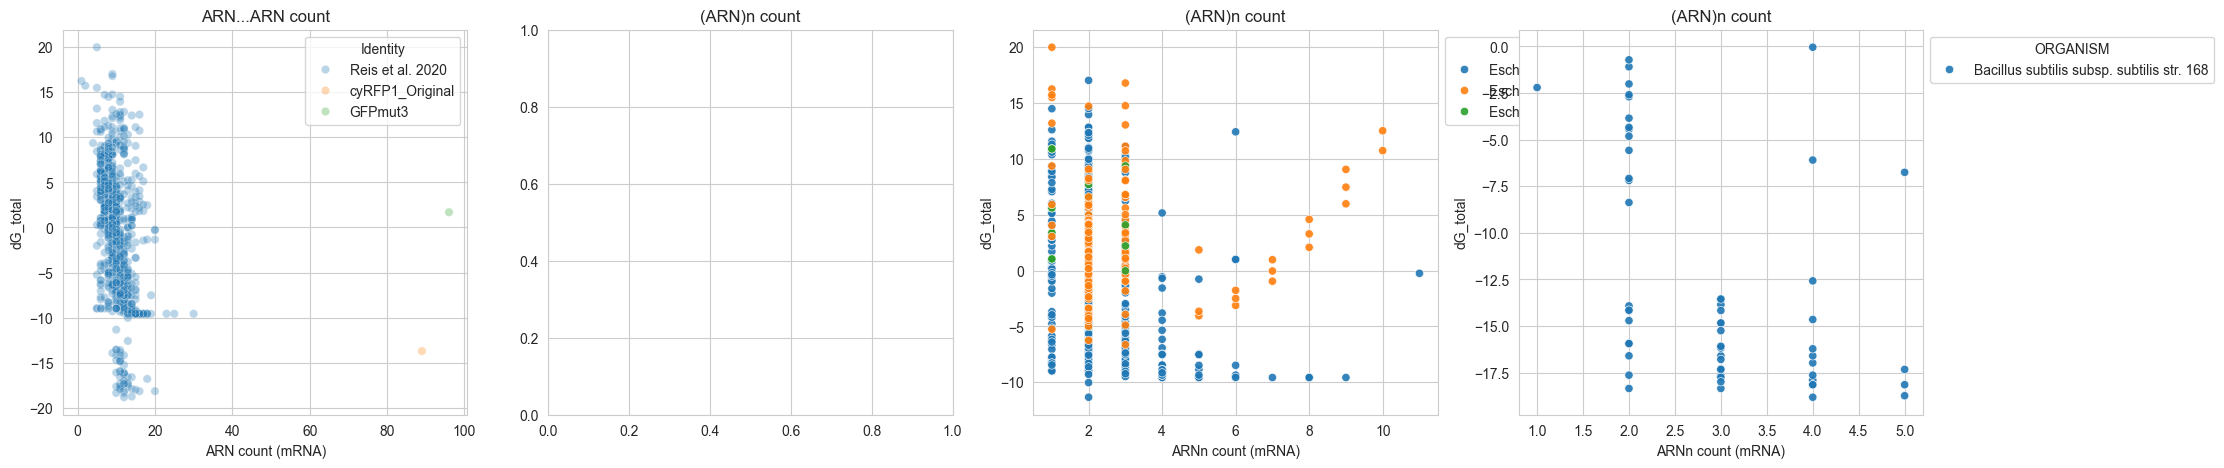

In [32]:
n_cols = 2
n_rows = int(np.ceil((1 + df_all['Organism (general)'].nunique()) / n_cols))
fig, axs = plt.subplots(1, n_rows, figsize=(6*n_rows, 5))
g = sns.scatterplot(df_all.sort_values('Is mRNA'), x="ARN count (mRNA)", y="dG_total", hue='Identity', alpha=0.3, ax=axs.flat[0])
axs.flat[0].set_title('ARN...ARN count')
for i, organism in enumerate(df_all['Organism (general)'].unique()):
    g = sns.scatterplot(df_all[df_all['Organism (general)'] == organism], 
                        x="ARNn count (mRNA)", y="dG_total", hue='ORGANISM', alpha=0.9, ax=axs.flat[i+1])
    if g.get_legend() is not None:
        sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    axs.flat[i+1].set_title('(ARN)n count')

plt.suptitle('dG predicted by RBS Calculator vs. ARN motifs')
plt.tight_layout()

# A-richness

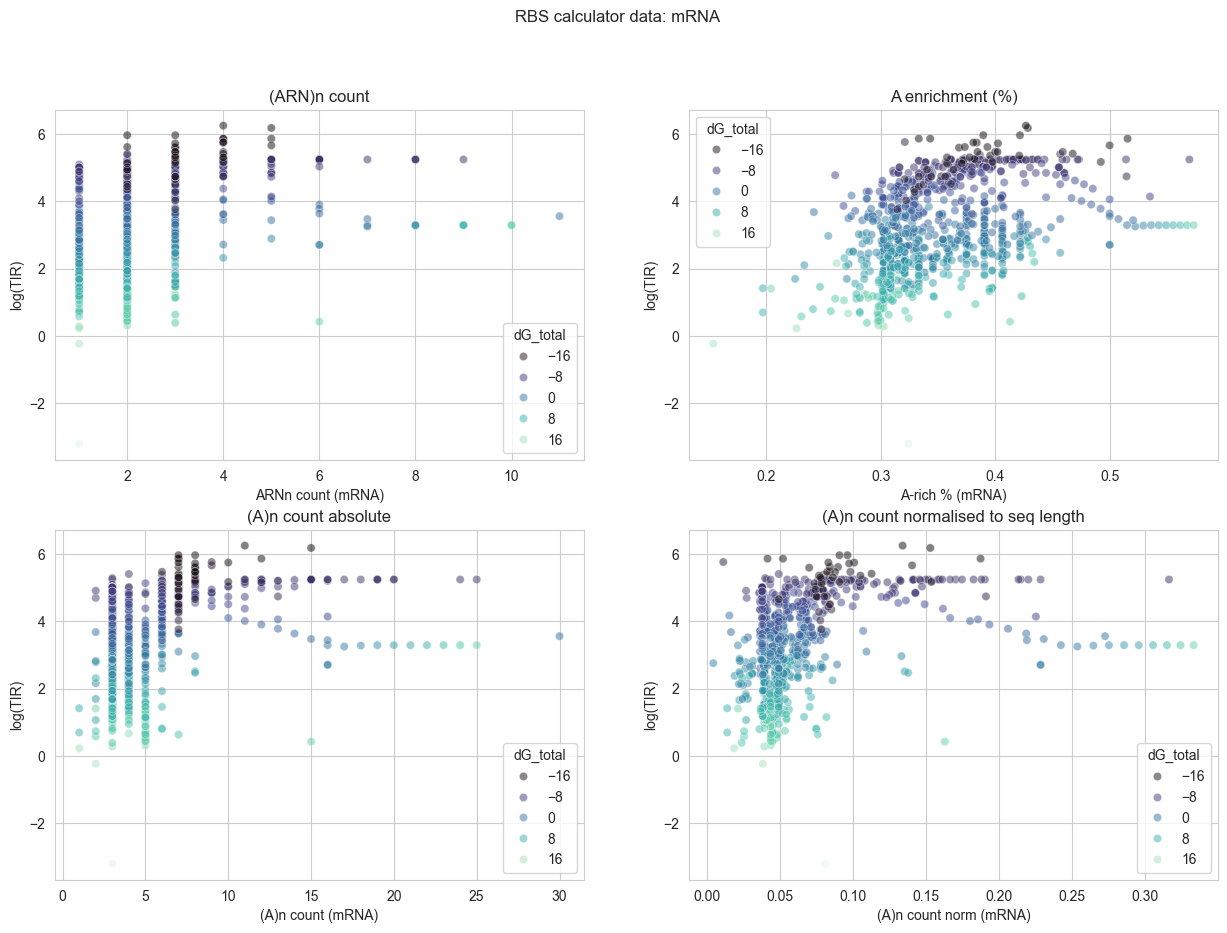

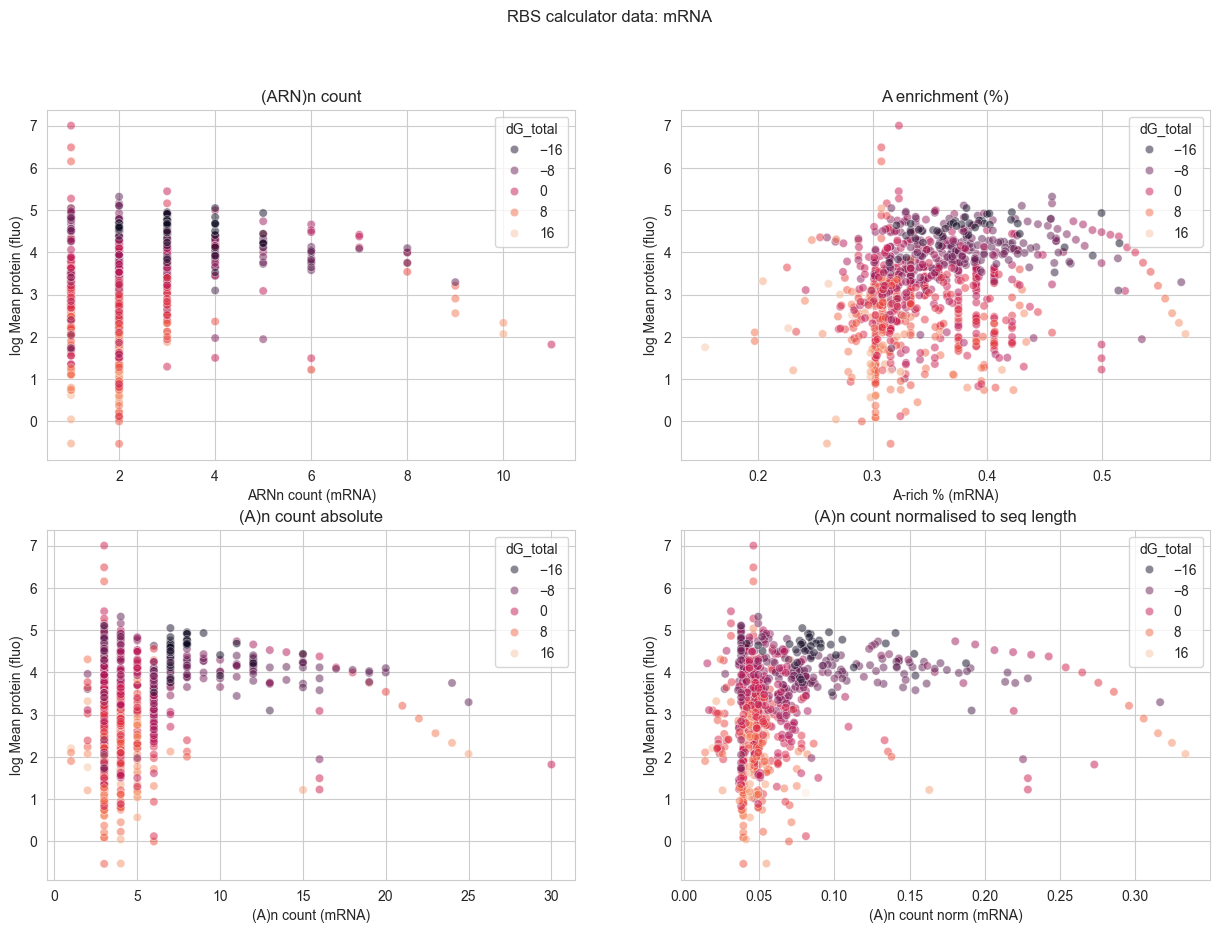

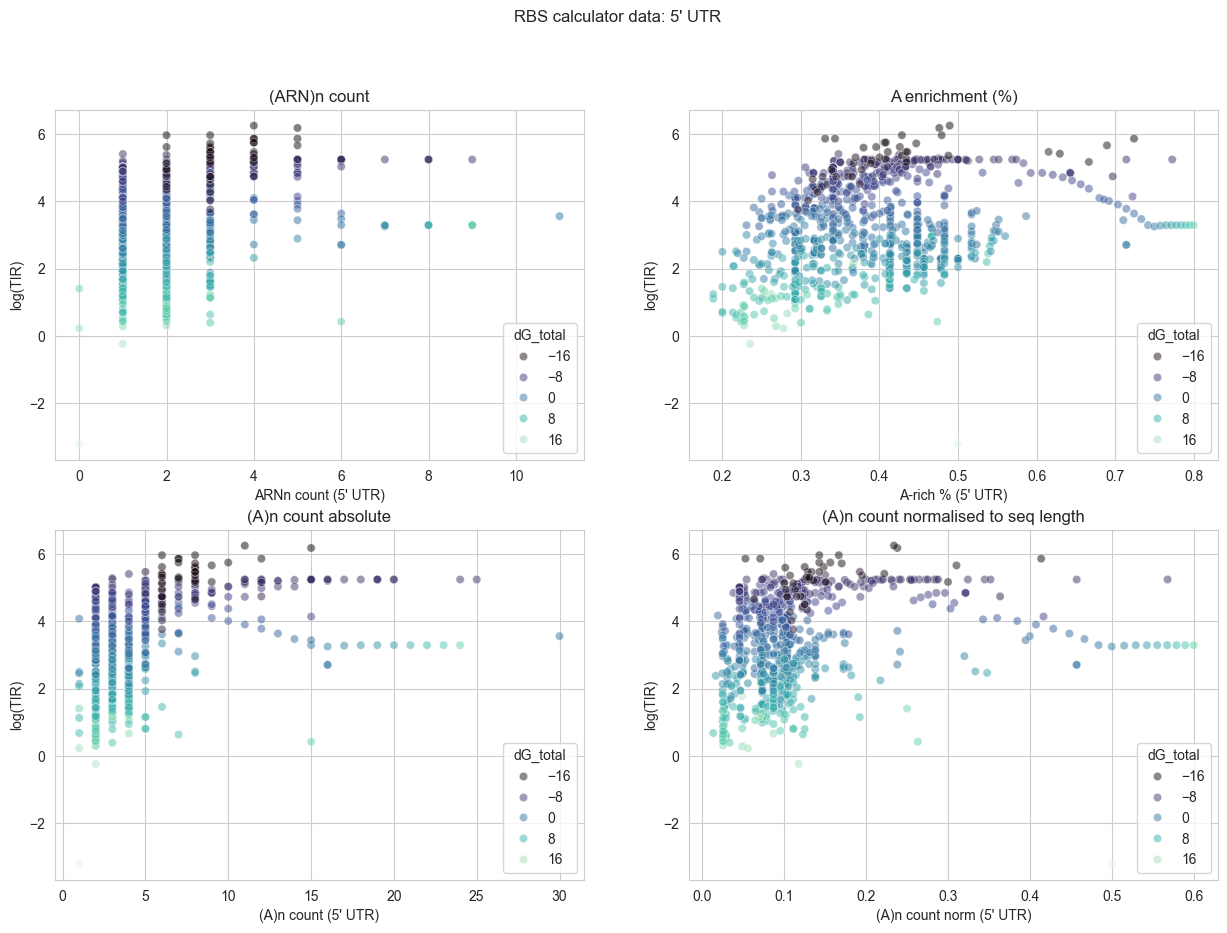

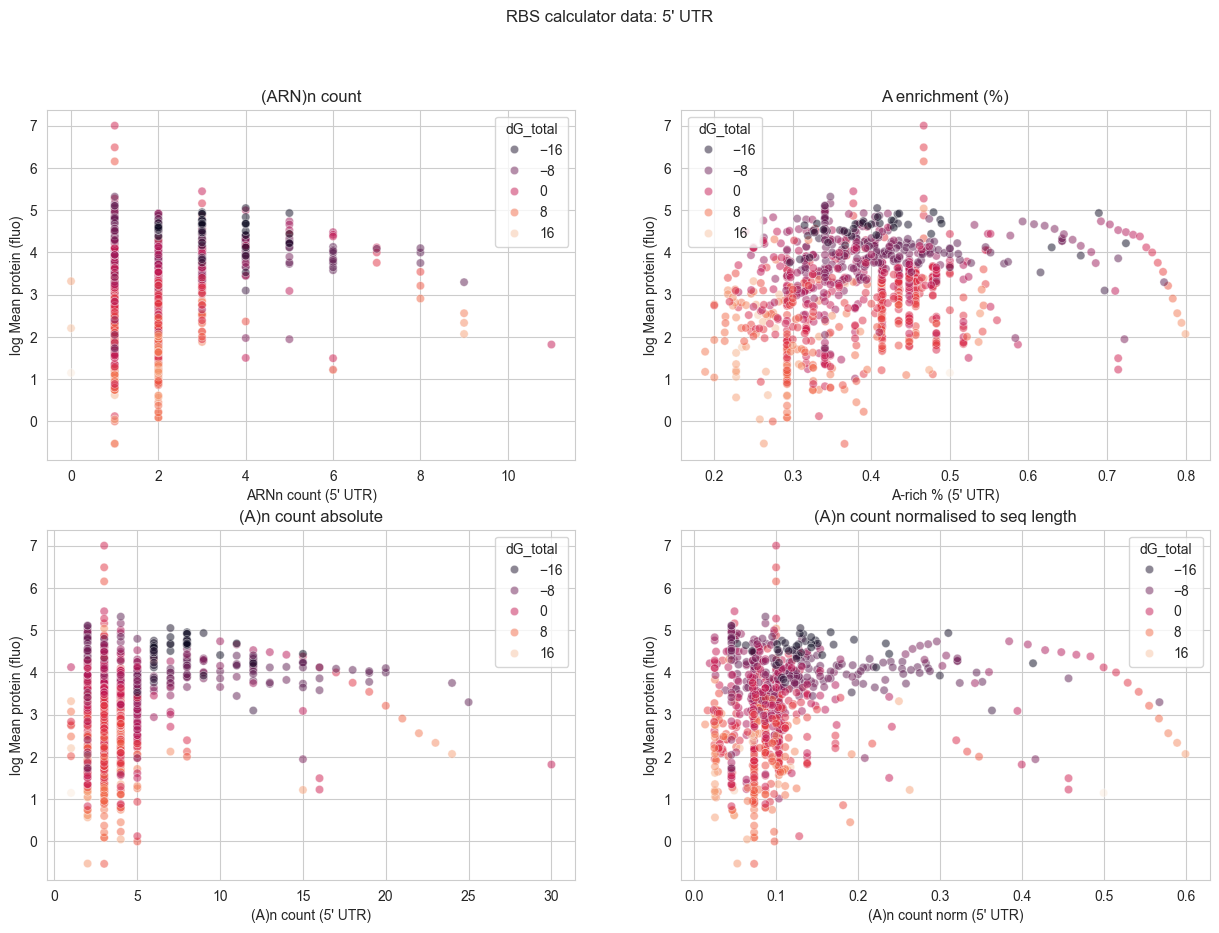

In [10]:
for seq in ['mRNA', "5' UTR"]:
    for k in ['log(TIR)', 'log Mean protein (fluo)']:

        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        g = sns.scatterplot(df_all.sort_values('Is mRNA'), x=f"ARNn count ({seq})", y=k, hue='dG_total', alpha=0.5, ax=axs.flat[0],
        palette='rocket' if 'protein' in k else 'mako')
        axs.flat[0].set_title('(ARN)n count')
        g = sns.scatterplot(df_all.sort_values('Is mRNA'), x=f"A-rich % ({seq})", y=k, hue='dG_total', alpha=0.5, ax=axs.flat[1],
        palette='rocket' if 'protein' in k else 'mako')
        axs.flat[1].set_title('A enrichment (%)')
        g = sns.scatterplot(df_all.sort_values('Is mRNA'), x=f"(A)n count ({seq})", y=k, hue='dG_total', alpha=0.5, ax=axs.flat[2],
        palette='rocket' if 'protein' in k else 'mako')
        axs.flat[2].set_title('(A)n count absolute')
        g = sns.scatterplot(df_all.sort_values('Is mRNA'), x=f"(A)n count norm ({seq})", y=k, hue='dG_total', alpha=0.5, ax=axs.flat[3],
        palette='rocket' if 'protein' in k else 'mako')
        axs.flat[3].set_title('(A)n count normalised to seq length')

        plt.suptitle(f'RBS calculator data: {seq}')
        savetxt = ('TIR' if k == 'log(TIR)' else 'Prot') + seq.split("'")[0]
        plt.savefig(os.path.join(top_dir, f'A_enrichment_{savetxt}.png'), dpi=300)

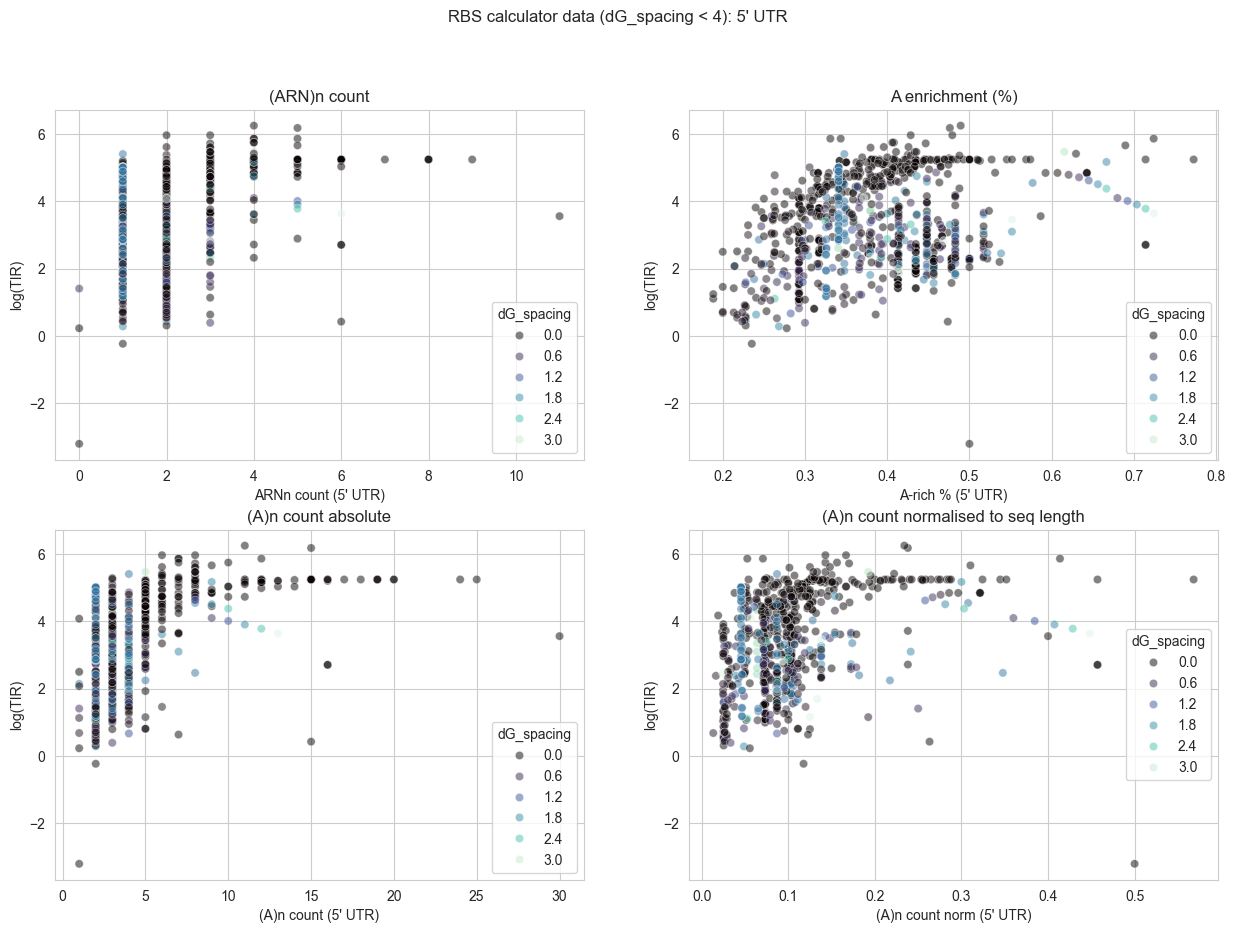

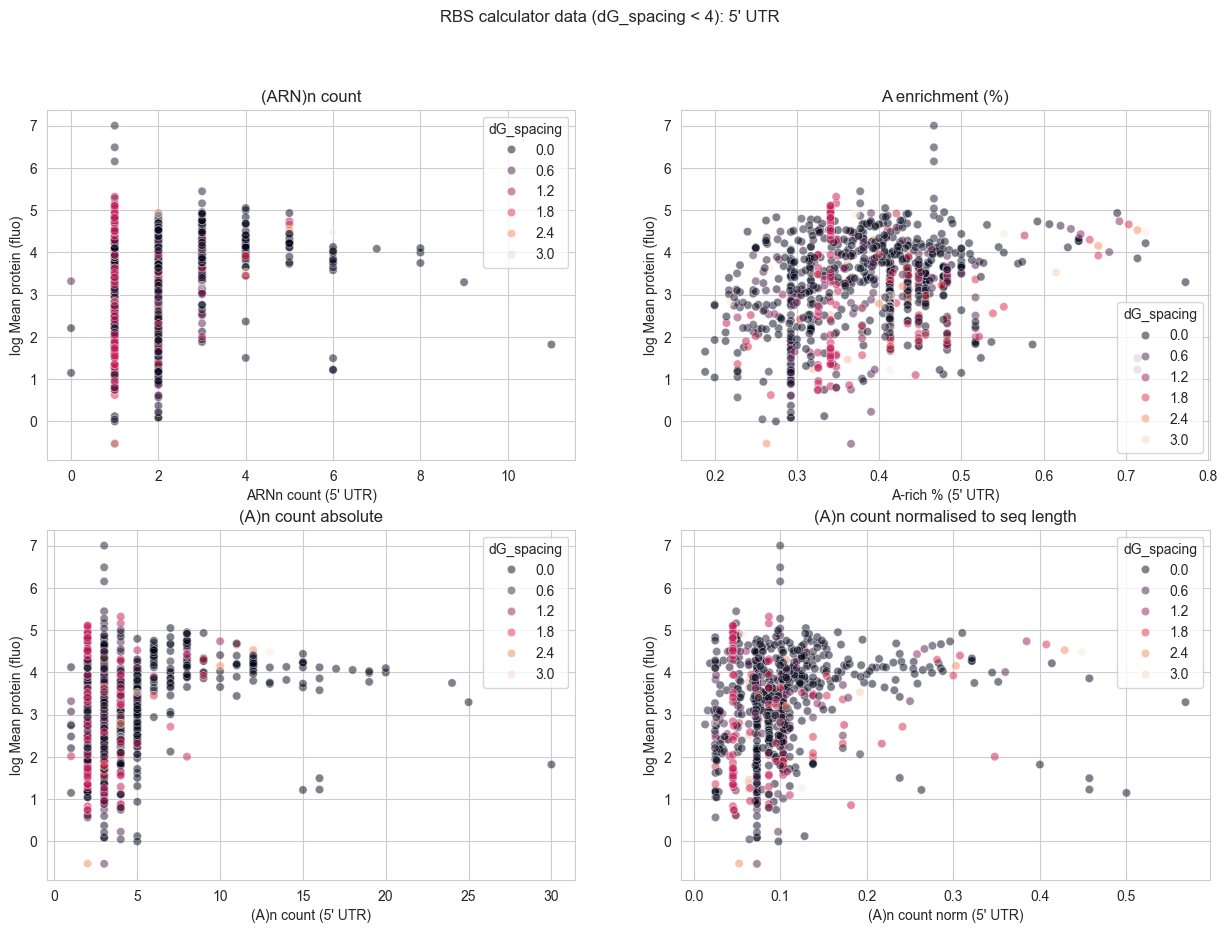

In [11]:
thresh_dg_spacing = 4
df_lowspacing = df_all[df_all['dG_spacing'] < thresh_dg_spacing]

for seq in ["5' UTR"]:
    for k in ['log(TIR)', 'log Mean protein (fluo)']:

        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        g = sns.scatterplot(df_lowspacing.sort_values('Is mRNA'), x=f"ARNn count ({seq})", y=k, hue='dG_spacing', alpha=0.5, ax=axs.flat[0],
        palette='rocket' if 'protein' in k else 'mako')
        axs.flat[0].set_title('(ARN)n count')
        g = sns.scatterplot(df_lowspacing.sort_values('Is mRNA'), x=f"A-rich % ({seq})", y=k, hue='dG_spacing', alpha=0.5, ax=axs.flat[1],
        palette='rocket' if 'protein' in k else 'mako')
        axs.flat[1].set_title('A enrichment (%)')
        g = sns.scatterplot(df_lowspacing.sort_values('Is mRNA'), x=f"(A)n count ({seq})", y=k, hue='dG_spacing', alpha=0.5, ax=axs.flat[2],
        palette='rocket' if 'protein' in k else 'mako')
        axs.flat[2].set_title('(A)n count absolute')
        g = sns.scatterplot(df_lowspacing.sort_values('Is mRNA'), x=f"(A)n count norm ({seq})", y=k, hue='dG_spacing', alpha=0.5, ax=axs.flat[3],
        palette='rocket' if 'protein' in k else 'mako')
        axs.flat[3].set_title('(A)n count normalised to seq length')

        plt.suptitle(f'RBS calculator data (dG_spacing < {thresh_dg_spacing}): {seq}')
        savetxt = ('TIR' if k == 'log(TIR)' else 'Prot') + seq.split("'")[0]
        plt.savefig(os.path.join(top_dir, f'Lowspacing_A_enrichment_{savetxt}.png'), dpi=300)

In [12]:
df['DATASET'].unique()

array(['EspahBorujeni_NAR_2013', 'EspahBorujeni_NAR_2015',
       'EspahBorujeni_JACS_2016', 'EspahBorujeni_Footprint',
       'EspahBorujeni_Bsubtilis_2016', 'Salis_Nat_Biotech_2009',
       'Farasat_MSB_2014', 'Tian_NAR_2015', 'Mimee_Cell_Sys_2015',
       'Bonde_NatMethods_IC_2016', 'Egbert_PNAS_2012', 'Hecht_NAR_2016',
       'Beck_PLoS_2016'], dtype=object)

# RNA with high yError

Output file: data/24_analyse_RBS_data_joint/rna_high_error.png

Output file: /tmp/tmpc_z8itk9.svg



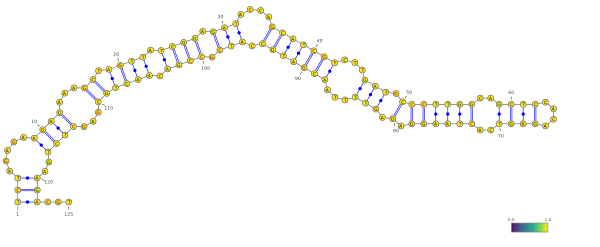

In [13]:
seq = df_all[df_all['yError'] > 120]['used_mRNA_sequence'].iloc[0]
folded = RNA.fold_compound(seq)
sstructure, mfe = folded.mfe()
sstructure = df_all[df_all['yError'] > 120]['initial_fold'].iloc[0]
draw_rna_nucolor_varna(sstructure, seq, np.ones(len(seq)),
                       out_file=f'data/24_analyse_RBS_data_joint/rna_high_error.png',
                       resolution=10, 
                       palette='viridis', # 'RdBu'
                       caption='',
                       algorithm='radiate')